Notebook written by Roger Creel  
Data analysis for Auderset et al., 2024 Paleoceanography 
Oct 26, 2022


### Question: How much North vs. South Atlantic continental shelf is exposed 200-0 ka?

In [1]:
# uses mwp1a_2 environment
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

%matplotlib inline
import spharm as ps
from scipy import interpolate as interp
# import pyshtools as sh 
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

import time
import math
import glob
import os
import netCDF4 as nc

from netCDF4 import Dataset
from pathlib import Path
from scipy.io import loadmat
from IPython.display import HTML, display

from sph_funcs import Oc_func, make_tl, make_el
from sph_funcs import m_to_l_order, load_data


######## Convenience Functions #############

def add_features(ax):
    """ """
    ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')
    ax.add_feature(ocean_50m, color='lightgray', zorder=0)
    ax.add_feature(land_50m, color='white', zorder=1)
    ax.gridlines(linewidth=1, color='white', alpha=0.5, draw_labels=True, zorder=4)
    ax.coastlines(resolution='50m', zorder=3)

    return ax

############################################

projection=ccrs.PlateCarree()


ModuleNotFoundError: No module named 'spharm'

# Load topography

In [ ]:
## ------ Load topo, GR_mask, WAIS mask, lat and lon on GL grids ---- ## 

topo_ice = pd.read_csv('runfiles/Model_etopo_ice_15.txt', sep=" ", header=None, names=['lon', 'lat', 'topo'])
lat_GL = pd.read_csv('runfiles/Model_lat_GL256.txt', sep=" ", header=None, names=['lat'], usecols=range(0,1))
lon_GL = pd.read_csv('runfiles/Model_lon_GL256.txt', sep=" ", header=None, names=['lon'], usecols=range(0,1))

# parameters
a = 6.371e6     #earth radius (meters)
maxdeg = 256
nlats, nlons = maxdeg, maxdeg*2
ages_interp = np.arange(0, 200, 0.25)[::-1]  # ages for common ref. 

### -----  Arrange data into arrays & interpolate ------## 

# Not interpolated
lon_in = topo_ice.lon.unique() # shape (1440,)
lat_in = topo_ice.lat.unique() # shape (720,)

#already on GL grid
lon_out = lon_GL.values.squeeze() # shape (512,)
lon_out[0] = 0.1; lon_out[-1] = 359.9; # avoid white gap at edges
lat_out = lat_GL.values.squeeze() # shape (256,)
lat_out[0] = 90; lat_out[-1] = -90; 

TOPO_ice = load_data(topo_ice)

#Interpolate topo onto GL grid
topo_interp = interp.interp2d(lon_in, lat_in[::-1], TOPO_ice)
TOPO_interp = topo_interp(lon_out, lat_out)

## --------- Ocean function ----------------#
sph = ps.Spharmt(nlons, nlats, rsphere=a, gridtype='gaussian', legfunc='stored')

#Filter topography with ocean function
TOPO_interp_new = TOPO_interp.copy()
topo_oc = Oc_func(TOPO_interp_new)

# Oc function of topo into Spherical harmonics
topo_oc_sh = sph.grdtospec(topo_oc)

print('done')

topo_swapped = np.concatenate([TOPO_interp[:,256:], TOPO_interp[:,:256]], axis=1)
ds_topo = xr.Dataset({"topo":(["lat", "lon"], topo_swapped)
           },
           coords={
               "lat":lat_out,
               "lon": lon_out - 180,
           }
          ).topo

if 1: 
    topo_swapped_hr = np.concatenate([TOPO_ice[:,720:], TOPO_ice[:,:720]], axis=1)
    ds_topo_hr = xr.Dataset({"topo":(["lat", "lon"], topo_swapped_hr)
               },
               coords={
                   "lat":lat_in,
                   "lon": lon_in - 180,
               }
              ).topo

done


# Make mask to select South Atlantic vs. North Atlantic

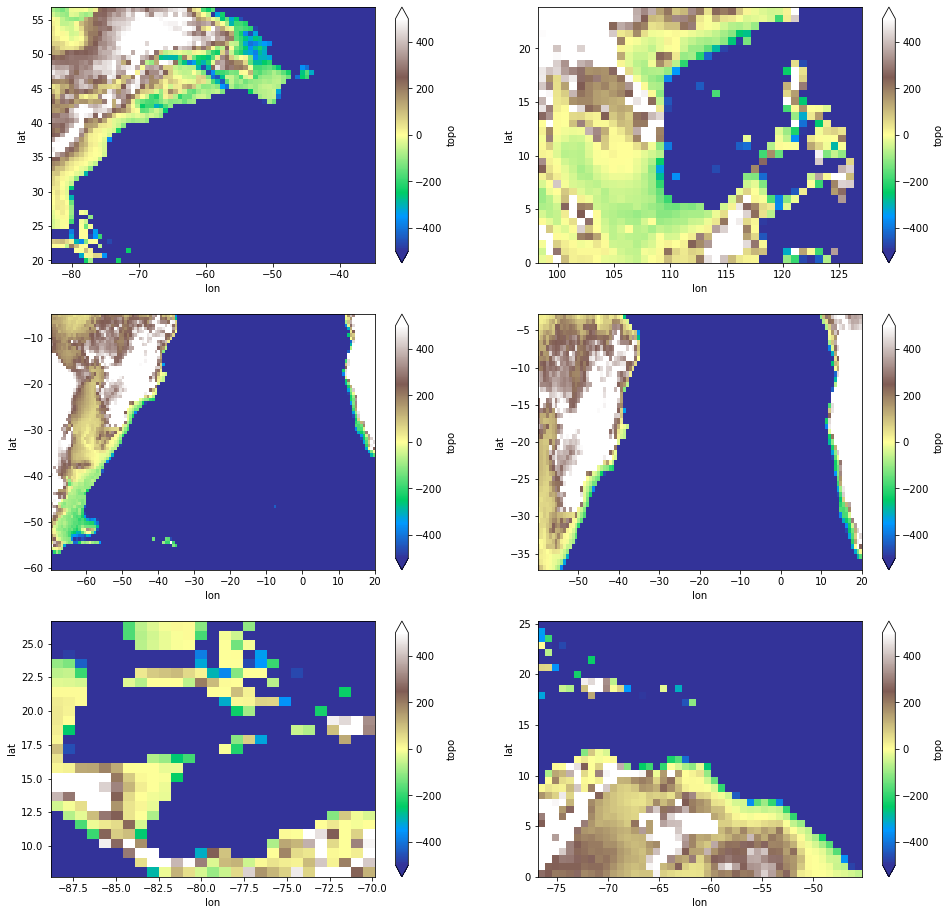

In [ ]:
def get_atl(ds, which, flip=False):
    
    natl = {'lon':(-83, -35), 'lat':(20, 57)}
    satl = {'lon':[-70, 20], 'lat':[-60, -5]}
    s_atl_n = {'lon':[-60, 20], 'lat':[-37, -3]}

    car_gom = {'lon':[-100, -70], 'lat':[10, 31]}
    wcarib = {'lon':[-89, -70], 'lat':[8, 27]}
    ecarib = {'lon':[-77, -45], 'lat':[0, 25]}
    scs = {'lon':[98, 127], 'lat':[0, 24]}
    world = {'lon':[-180, 180], 'lat':[-90, 90]}
    
    loc = satl
    if 'natl' in which:
        loc = natl
    elif 'wcarib' in which:
        loc = wcarib
    elif 'scs' in which:
        loc = scs
    elif 'ecarib' in which:
        loc = ecarib
    elif 's_atl_n' in which:
        loc = s_atl_n
    elif 'world' in which:
        loc = world
    
    ds = ds.sel(lon=slice(loc['lon'][0], loc['lon'][1]),)
    ds_out = ds.sel(lat=slice(loc['lat'][0], loc['lat'][1]))
    if flip:
        ds_out = ds.sel(lat=slice(loc['lat'][1], loc['lat'][0]))
        
    return ds_out
    

# ds_natl = get_atl(ds_topo, 'natl', flip=True)
# ds_satl = get_atl(ds_topo, 'satl', flip=True)
# ds_carib = get_atl(ds_topo, 'carib', flip=True)
locs = ['natl', 'satl', 's_atl_n', 'wcarib', 'ecarib', 'scs']
ds_natl, ds_satl, ds_satl_n, ds_wcarib, ds_ecarib, ds_scs = [get_atl(ds_topo, l, flip=1) for l in locs]



fig, axes = plt.subplots(3, 2, figsize=(16, 16))
ax = axes.flatten()
ds_natl.plot(ax=ax[0], vmin=-500, vmax=500, cmap='terrain')
ds_scs.plot(ax=ax[1], vmin=-500, vmax=500, cmap='terrain')

ds_satl.plot(ax=ax[2], vmin=-500, vmax=500, cmap='terrain')
ds_satl_n.plot(ax=ax[3], vmin=-500, vmax=500, cmap='terrain')

ds_wcarib.plot(ax=ax[4], vmin=-500, vmax=500, cmap='terrain')
ds_ecarib.plot(ax=ax[5], vmin=-500, vmax=500, cmap='terrain')


# Make mask for continental margin: choose modern topo between 0 and -250 m

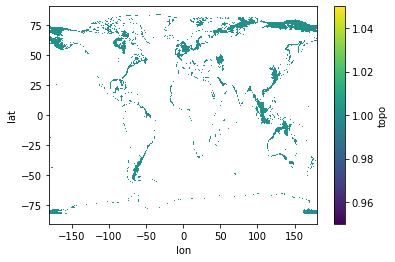

In [ ]:
ds_shelfmask = xr.where((ds_topo < 10) & (ds_topo > -150), 1, np.nan)
ds_shelfmask.plot()
plt.show()

# Mask topo for ocean

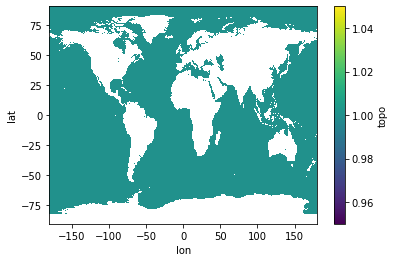

In [ ]:
ds_ocmask = xr.where((ds_topo < 10), 1, np.nan)
ds_ocmask.plot()

# Load ICE6G/Lambeck Ice Sheet

In [ ]:
ds = xr.open_dataset('runfiles/Model_ice.nc')

ice_swap = np.concatenate([ds.thk.values[:,256:,:], ds.thk.values[:,:256,:]], axis=1)

ds_ice = xr.Dataset({"thk":(["age", "lon", "lat", ], ice_swap)
           },
           coords={
                "age":ds.age.values/1000,
                 "lon": lon_out - 180,
                 "lat":lat_out,
           }
          ).thk.interp(age=ages_interp)



## Mask anywhere with ice, b/c no sed production under ice sheet.


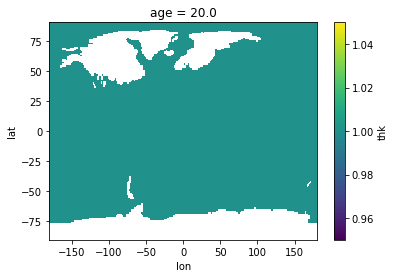

In [ ]:
ds_icemask = xr.where((ds_ice > 0), np.nan, 1)

ds_icemask.sel(age=20, method='nearest').transpose().plot()

# Add ice and shelf masks 

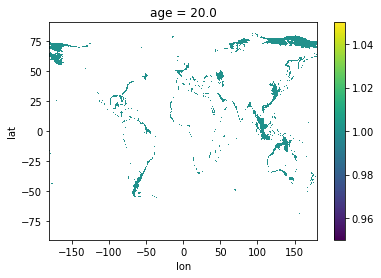

In [ ]:
ds_iceshelfmask = ds_icemask * ds_shelfmask
ds_iceshelfmask.sel(age=20, method='nearest').transpose().plot()

# Load Glacial isostatic adjustment (GIA) model of relative sea level 200 ka - present

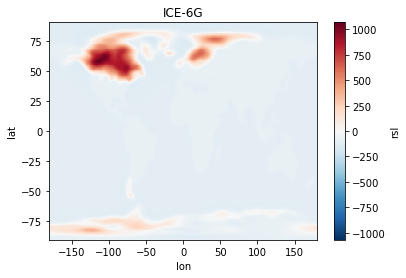

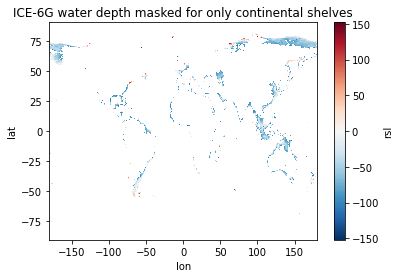

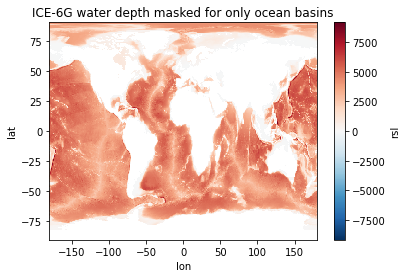

In [ ]:
ds = xr.open_dataset('runfiles/Model_rsl.nc')

rsl_swap = np.concatenate([ds.RSL.values[:,256:,:], ds.RSL.values[:,:256,:]], axis=1)

ages = ds.TIME.values/1000
ds_6g = xr.Dataset({"rsl":(["age", "lon", "lat", ], rsl_swap)
           },
           coords={
                "age":ages,
                 "lon": lon_out - 180,
                 "lat":lat_out,
           }
          ).interp(age=ages_interp)

esl = ds.ESL.values

# subtract topo to get water depth 
ds_6g_wd = ds_6g - ds_topo

# mask water depth to only show on continental shelves
ds_6gmask = ds_6g_wd * ds_iceshelfmask

# Mask water depth to only show in ocean basin
ds_6gmask_oc = ds_6g_wd * ds_ocmask


ds_6g.rsl.sel(age=20, method='nearest').transpose().plot()
plt.title('ICE-6G')
plt.show()


ds_6gmask.rsl.sel(age=20, method='nearest').transpose().plot() 
plt.title('ICE-6G water depth masked for only continental shelves')
plt.show()

ds_6gmask_oc.rsl.sel(age=20, method='nearest').transpose().plot() 
plt.title('ICE-6G water depth masked for only ocean basins')
plt.show()

# Save RSL

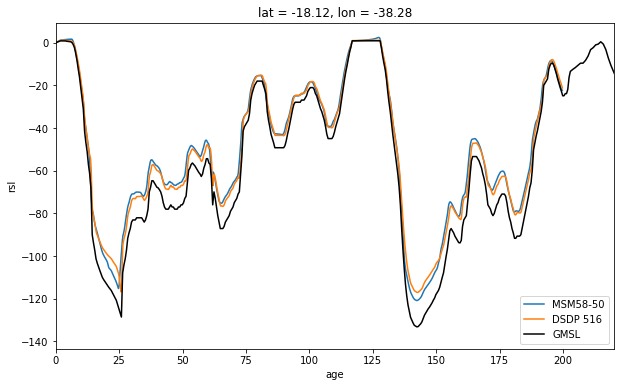

In [ ]:
# Site lat lons
lat_5850, lon_5850 = 35.39845385883307, -75.73213682511252

lat_516, lon_516 = -18.11674288518536, -38.2769386178288

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ds_6g.rsl.interp(lat=lat_5850, lon=lon_5850).plot(ax=ax, label='MSM58-50')
ds_6g.rsl.interp(lat=lat_516, lon=lon_516).plot(ax=ax, label='DSDP 516')
ax.plot(ages, esl, color='k', label='GMSL')

ax.set_xlim(0, 220)
ax.legend()

<AxesSubplot:xlabel='age'>

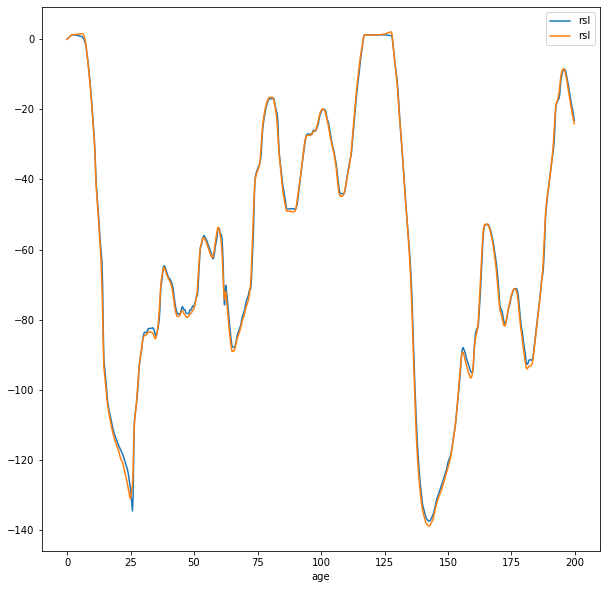

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pd.read_csv('output/timeseries/DSDP516.csv').plot(ax=ax, x='age', y='rsl')
pd.read_csv('output/timeseries/MSM58-50-3.csv').plot(ax=ax, x='age', y='rsl')

In [ ]:
df = ds_6g.rsl.interp(lat=lat_5850, lon=lon_5850).to_dataframe().reset_index()
df['site'] = 'MSM58-50'

df2 = ds_6g.rsl.interp(lat=lat_5850, lon=lon_5850).to_dataframe().reset_index()
df2['site'] = 'DSDP-516'

pd.concat([df, df2]).to_csv('output/timeseries/rsl_dsdp516_msm5850.csv')



In [ ]:
pd.DataFrame(data={'MSM58-50':[lat_5850, lon_5850], 'DSDP-516':[lat_516, lon_516]}, index=['lat', 'lon'])


,MSM58-50,DSDP-516
lat,35.398454,-18.116743
lon,-75.732137,-38.276939


# Make mask to consider only RSL on current continental shelf

### Map timeslices of continental shelf

In [ ]:
if True:

    for loc in ['s_atl_n']: # ['natl', 'satl', 'carib', 'scs']:

        # choose only atlantic region
        d_dry = get_atl(ds_6gmask, loc, flip=True)

        # select areas where RSL is not zero
        # d_dry = xr.where(d != 0, d, np.nan)

        # Mask ice sheet model to only show areas with ice 
        ds_iceplt = xr.where(ds_ice < 1, np.nan, ds_ice)
        ds_iceplt = get_atl(ds_iceplt, loc, flip=True)


        for i in np.arange(200)[::-10]:

            fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw=dict(projection=projection))

            ds_iceplt.sel(age=i, method='nearest').transpose().plot(ax=ax, 
                                                                    transform=projection,
                                                                   zorder=10,
                                                                     vmin=0,
                                                                     vmax=2000,
                                                                    cmap='Greys_r',
                                                                   cbar_kwargs={'shrink':0.5,
                                                                               'pad':0.1,
                                                                               'extend':'both',
                                                                                'location':'left',
                                                                                'label':'Ice thickness (m)'})


            d_dry.rsl.sel(age=i, method='nearest').transpose().plot(ax=ax, 
                                                                transform=projection, 
                                                               zorder=10,
                                                                    vmin=-20,
                                                                    vmax=20,
                                                                    cmap='RdBu_r',
                                                                   cbar_kwargs={'shrink':0.5,
                                                                               'pad':0.1,
                                                                                'extend':'both',
                                                                                'label':'Water Depth (m)'}) #vmin=-100, vmax=10
            ax = add_features(ax)
            fig.savefig(f'figs/{loc}/{loc}{i}')
            plt.show()



# Count area of shelves that is exposed: Mask to keep only cells above water

## Write code to calculate area of each grid cell

In [ ]:
from __future__ import division

import json
from math import pi, sin

# __version__ = '1.1.1'
WGS84_RADIUS = 6378137


def rad(value):
    return value * pi / 180


def ring__area(coordinates):
    """
    Calculate the approximate _area of the polygon were it projected onto
        the earth.  Note that this _area will be positive if ring is oriented
        clockwise, otherwise it will be negative.
    Reference:
        Robert. G. Chamberlain and William H. Duquette, "Some Algorithms for
        Polygons on a Sphere", JPL Publication 07-03, Jet Propulsion
        Laboratory, Pasadena, CA, June 2007 http://trs-new.jpl.nasa.gov/dspace/handle/2014/40409
    @Returns
    {float} The approximate signed geodesic _area of the polygon in square meters.
    """

    assert isinstance(coordinates, (list, tuple))

    _area = 0
    coordinates_length = len(coordinates)

    if coordinates_length > 2:
        for i in range(0, coordinates_length):
            if i == (coordinates_length - 2):
                lower_index = coordinates_length - 2
                middle_index = coordinates_length - 1
                upper_index = 0
            elif i == (coordinates_length - 1):
                lower_index = coordinates_length - 1
                middle_index = 0
                upper_index = 1
            else:
                lower_index = i
                middle_index = i + 1
                upper_index = i + 2

            p1 = coordinates[lower_index]
            p2 = coordinates[middle_index]
            p3 = coordinates[upper_index]

            _area += (rad(p3[0]) - rad(p1[0])) * sin(rad(p2[1]))

        _area = _area * WGS84_RADIUS * WGS84_RADIUS / 2

    return _area


def polygon__area(coordinates):

    assert isinstance(coordinates, (list, tuple))

    _area = 0
    if len(coordinates) > 0:
        _area += abs(ring__area(coordinates[0]))

        for i in range(1, len(coordinates)):
            _area -= abs(ring__area(coordinates[i]))

    return _area


def area(geometry):

    if isinstance(geometry, str):
        geometry = json.loads(geometry)

    assert isinstance(geometry, dict)

    _area = 0

    if geometry['type'] == 'Polygon':
        return polygon__area(geometry['coordinates'])
    elif geometry['type'] == 'MultiPolygon':
        for i in range(0, len(geometry['coordinates'])):
            _area += polygon__area(geometry['coordinates'][i])

    elif geometry['type'] == 'GeometryCollection':
        for i in range(0, len(geometry['geometries'])):
            _area += area(geometry['geometries'][i])

    return _area


def get_sq_km(r, ds):
    diff = abs(np.diff(ds.lat.values)[0]/2)
    latlo = r.lat - diff
    lathi = r.lat + diff
    lonlo = r.lon - diff
    lonhi = r.lon + diff
    box = [[[lonlo, latlo], [lonlo, lathi], [lonhi, lathi], [lonhi, latlo], [lonlo, latlo]]]

    sq_km = area({'type':'Polygon','coordinates':box}) / 1e6
    
    return sq_km

def calculate_area(ds, age):
    
    df = ds.rsl.sel(age=age).to_pandas().unstack().reset_index().rename({0:'site'}, axis=1)# .melt()
    df_ll = df[pd.notna(df)['site']][['lat', 'lon']]

    summed_area = df_ll.apply(lambda r: get_sq_km(r, ds), axis=1).sum()   
    
    return summed_area


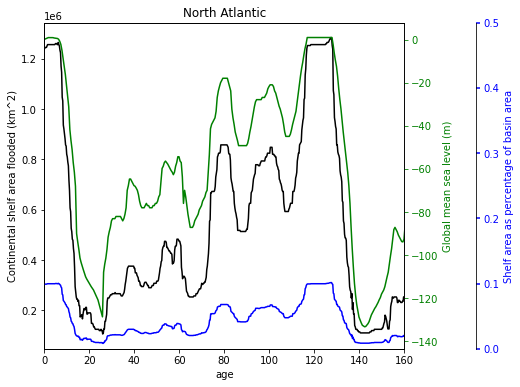

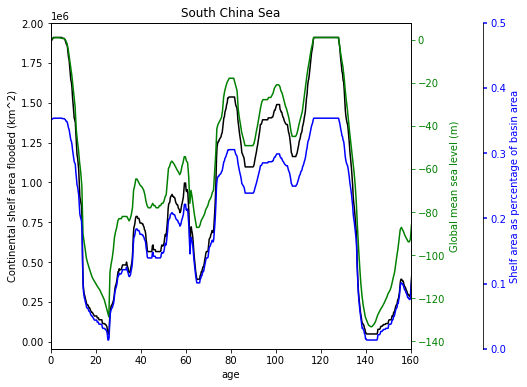

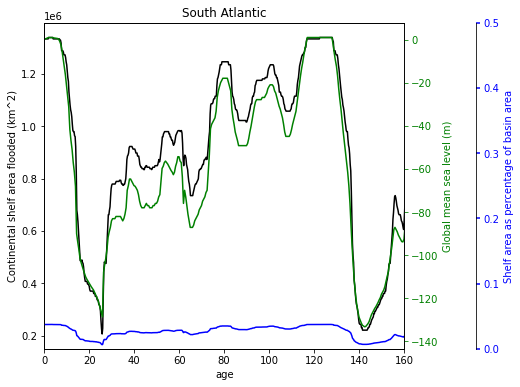

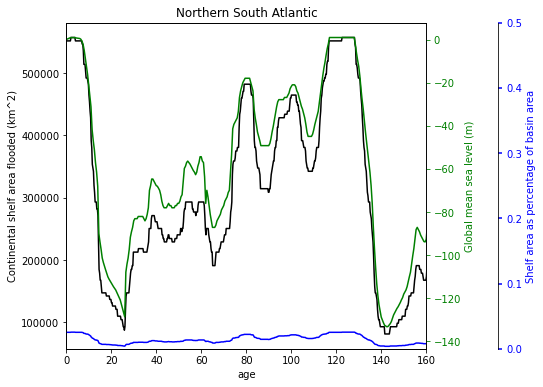

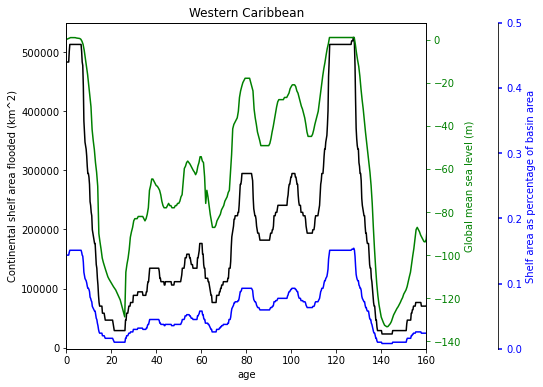

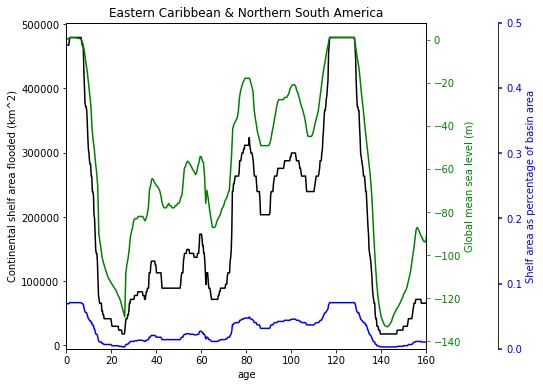

In [ ]:
#### select only WD & ocean basins where greater than zero, i.e. where location is under water
ds_fullmask = xr.where(ds_6gmask > 0, 1, np.nan)
ds_fullmask_oc = xr.where(ds_6gmask_oc > 0, 1, np.nan)


locnames = {'natl': "North Atlantic",
           'satl': "South Atlantic",
            's_atl_n':"Northern South Atlantic",
           'wcarib': "Western Caribbean",
            'ecarib': "Eastern Caribbean & Northern South America",
           'scs': "South China Sea",
           }


for loc in ['natl', 'scs', 'satl', 's_atl_n', 'wcarib', 'ecarib']:
    
    # choose region
    ds_wet = get_atl(ds_fullmask, loc, flip=1)
    
    ds_wetoc = get_atl(ds_fullmask_oc, loc, flip=1)

    # Get rough area estimate by just summing number of grid cells
    ds_wet_sum = ds_wet.sum(['lat', 'lon']).rsl 
    ds_wetoc_sum = ds_wetoc.sum(['lat', 'lon']).rsl 
    ds_wet_frac = ds_wet_sum / ds_wetoc_sum
    
    # Calculate flooded area in square kilometers
    wet_area = [calculate_area(ds_wet, age) for age in ds_wet.age.values]
    # oc_area = [calculate_area(ds_wetoc, age) for age in ds_wetoc.age.values]

    da_wetarea = xr.DataArray(
                data=wet_area,
                dims=["age"],
                coords=dict(
                    age=ds_wet.age.values,
                ),
            )
    
    # da_ocarea = xr.DataArray(
    #             data=oc_area,
    #             dims=["age"],
    #             coords=dict(
    #                 age=ds_wet.age.values,
    #             ),
    #         ) 
    # da_wet_frac = da_wetarea / da_ocarea

    
    # plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    tkw = dict(size=4, width=1.5)

    ax0 = ax.twinx()
    ax0.yaxis.set_label_position("right")
    ax0.yaxis.tick_right()
    [a.set_xlim(0, 160) for a in [ax, ax0]]

    da_wetarea.plot(ax=ax, color='k')
    # ds_wet_sum.plot(ax=ax, color='k')
    # ax.set_ylabel('Continental shelf area flooded (unit = grid cell)')
    # ax.set_ylabel('Percent shelf area flooded (unit = grid cell)')
    ax.set_ylabel('Continental shelf area flooded (km^2)')
    
    ax1 = ax.twinx() 
    ax1.spines.right.set_position(("axes", 1.2))
    
    p1 = ds_wet_frac.plot(ax=ax1, color='blue')[0]
    # p1 = da_wet_frac.plot(ax=ax1, color='blue')[0]

    
    ax1.yaxis.label.set_color(p1.get_color())
    ax1.tick_params(axis='y', colors=p1.get_color(), **tkw)
    ax1.set_ylabel('Shelf area as percentage of basin area', color=p1.get_color())
    ax1.set_ylim(0, 0.5)



    ax0.plot(ages, esl, color='green')
    ax0.tick_params(axis='y', colors='green')
    ax0.set_ylabel('Global mean sea level (m)', color='green')
    ax.set_title(locnames[loc])
    
    
    fig.subplots_adjust(right=0.75)
    
    fig.savefig(f'figs/timeseries/{loc}_shelfflooded.png')
    plt.show()
    
    da_wetarea.to_netcdf(f'output/{loc}_shelfareaflooded.nc')
    da_wetarea.to_dataset(name='shelf_area').to_pandas().reset_index().to_csv(f'output/{loc}_shelfareaflooded.csv')
    ds_wet_frac.to_netcdf(f'output/{loc}_shelf_as_oc_pct.nc')
    ds_wet_frac.to_dataset(name='shelf_as_pct_of_basin').to_pandas().reset_index().to_csv(f'output/{loc}_shelf_as_oc_pct.csv')


    # ax.set_yscale('log')


# Pretty map of four locations showing LGM flooding

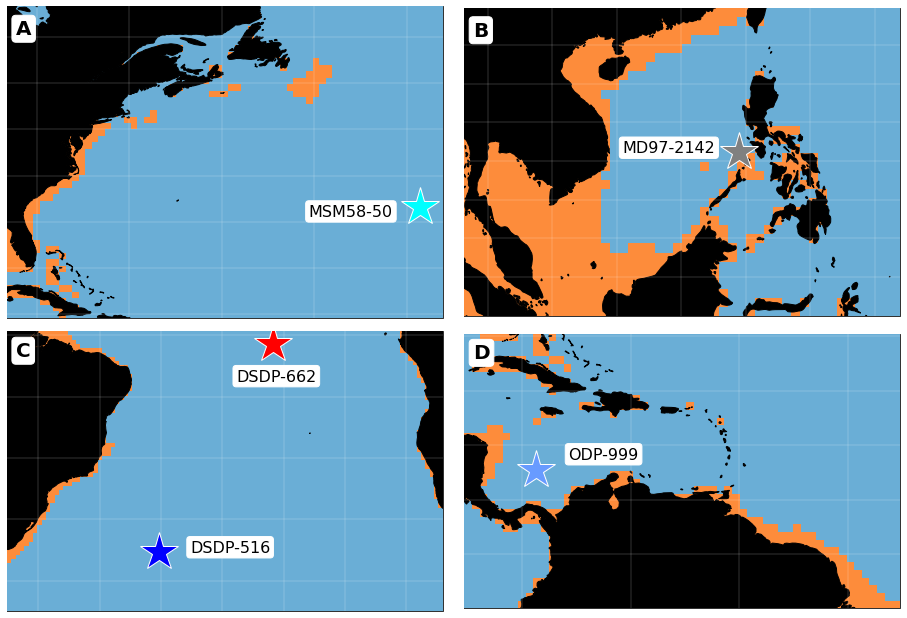

In [ ]:
import matplotlib as mpl
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker



lgmtime = 26
ds_lgm = ds_6g_wd.sel(age=lgmtime).rsl

ds_lgm_dry = xr.where(ds_lgm < 0, 1, np.nan) 
ds_lgm_wet = xr.where(ds_lgm > 0, 1, np.nan) 

ds_lgm_shelf = ds_lgm_dry * ds_shelfmask 
ds_lgm_notshelf = xr.where(ds_lgm_shelf == 1, np.nan, 1)

ds_lgm_land = ds_lgm_dry * ds_lgm_notshelf

ds_iceplt = xr.where(ds_ice < 1, np.nan, ds_ice)
# ds_iceplt = xr.where(ds_ice < 1, np.nan, 1)

ds_icelgm_plt = ds_iceplt.sel(age=lgmtime)

def get_atl(ds, which, flip=False):
    
    natl = {'lon':(-83, -36), 'lat':(20, 53)}
    satl = {'lon':[-70, 15], 'lat':[-65, -5]}
    s_atl_n = {'lon':[-55, 16], 'lat':[-45, 1]}

    car_gom = {'lon':[-100, -70], 'lat':[10, 31]}
    wcarib = {'lon':[-89, -70], 'lat':[8, 27]}
    ecarib = {'lon':[-85, -45], 'lat':[0, 25]}
    scs = {'lon':[98, 132], 'lat':[0, 24]}
    world = {'lon':[-180, 180], 'lat':[-90, 90]}
    
    loc = satl
    if 'natl' in which:
        loc = natl
    elif 'wcarib' in which:
        loc = wcarib
    elif 'scs' in which:
        loc = scs
    elif 'ecarib' in which:
        loc = ecarib
    elif 's_atl_n' in which:
        loc = s_atl_n
    elif 'world' in which:
        loc = world
    
    ds = ds.sel(lon=slice(loc['lon'][0], loc['lon'][1]),)
    ds_out = ds.sel(lat=slice(loc['lat'][0], loc['lat'][1]))
    if flip:
        ds_out = ds.sel(lat=slice(loc['lat'][1], loc['lat'][0]))
        
    return ds_out
    
    
def make_plotpart(ds, z, cmap, vmin, ax, add_colorbar=False):

    ds = get_atl(ds, loc, flip=1)
    
    ds.transpose().plot(ax=ax, 
                        transform=projection, 
                        zorder=z,
                        cmap=cmap,
                        vmin=vmin,
                        alpha=1,
                        add_colorbar=False,
                        )

fig, ax = plt.subplots(2, 2, figsize=(16, 12), subplot_kw=dict(projection=projection))
axes = ax.flatten()

# cmap = mpl.cm.get_cmap("Greys").copy()
# cmap.set_under(color='black')  
txts = ['A', 'B', 'C', 'D']


stars = { 
    'natl':['MSM58-50', 'cyan', 360 - 38 - 34/60, 31 + 39/60, -12, -1], # name, color, lon, lat, x, y
    's_atl_n':['DSDP-516', 'blue', 360 - 30 - 16/60, -35 - 17/60, 5, 0], 
    'scs':['MD97-2142', 'grey', 119 + 27/60, 12 + 41/60, -9, 0], 
    'ecarib':['ODP-999', '#689BFF', 360 - 78 - 44/60, 12 + 45/60, 3, 1]
}
bbox_kw=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.2')
fontsize=16

for loc, ax, txt in zip(['natl', 'scs', 's_atl_n', 'ecarib'], axes, txts):
    
    # Plot stars on each 
    # lat_5850, lon_5850 = 35.39845385883307, -75.73213682511252
    sitename, scolor, lon, lat, x, y = stars[loc]

    
    ax.plot(lon, lat, transform=projection, marker='*', zorder=30, 
            ms=40, color=scolor, mec='w', label=sitename)
    ax.text(lon+x, lat+y, sitename, transform=projection, zorder=100,
           bbox=bbox_kw, fontsize=fontsize) 

    if 's_atl_n' in loc:
        lon2 = 360 - 11 - 44/60
        lat2 = -1 - 23/60
        sitename2 = 'DSDP-662'
        scolor2='red'
        x= -6
        y= -6
        
        ax.plot(lon2, lat2 , transform=projection, marker='*', zorder=30, 
                ms=40, color=scolor2, mec='w', label=sitename2)  
        ax.text(lon2+x, lat2+y, sitename2, transform=projection, zorder=100,
               bbox=bbox_kw, fontsize=fontsize) 

    
    # ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')
    # ax.add_feature(ocean_50m, color='lightgray', zorder=0)
    ax.add_feature(land_50m, color='k', zorder=12)
    ax.gridlines(linewidth=0.4, color='white', alpha=0.5, draw_labels=False, zorder=13)
    
    # lon_formatter = cticker.LongitudeFormatter()
    # lat_formatter = cticker.LatitudeFormatter()
    # ax.xaxis.set_major_formatter(lon_formatter)
    # ax.yaxis.set_major_formatter(lat_formatter)
    # ax.grid(linewidth=0.4, color='w', alpha=0.5, linestyle='-', zorder=20)
    
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=False)
#     gl.xlabels_top = False
#     gl.ylabels_left = False
#     gl.ylabels_right=True
#     gl.xlines = True
    
#     lon_formatter = cticker.LongitudeFormatter()
#     lat_formatter = cticker.LatitudeFormatter()
#     gl.xlocator = mticker.FixedLocator(lon_formatter)
#     gl.ylocator = mticker.FixedLocator(lat_formatter)
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER
#     gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

    make_plotpart(ds_lgm_land, z=9, cmap='Oranges', vmin=1, ax=ax, add_colorbar=False)
    make_plotpart(ds_lgm_shelf, z=10, cmap='Oranges', vmin=1, ax=ax, add_colorbar=False)
    make_plotpart(ds_lgm_wet, z=10, cmap='Blues', vmin=1, ax=ax, add_colorbar=False)
    # make_plotpart(ds_icelgm_plt, z=15, cmap='Blues', vmin=0, ax=ax, add_colorbar=False)
    
    ax.text(0.02, 0.91, txt, transform=ax.transAxes, 
            zorder=20, color='k', fontsize=20, weight='bold',
           bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.2'))

    
[a.set_title('') for a in axes]
plt.subplots_adjust(hspace=-0.1, wspace=0.05)

fig.savefig('figs/shelfmaps/lgm_shelfareas.png', bbox_inches='tight')
fig.savefig('figs/shelfmaps/lgm_shelfareas.pdf', bbox_inches='tight')


# Pretty map of four locations showing percentage of last 160 kyr flooded

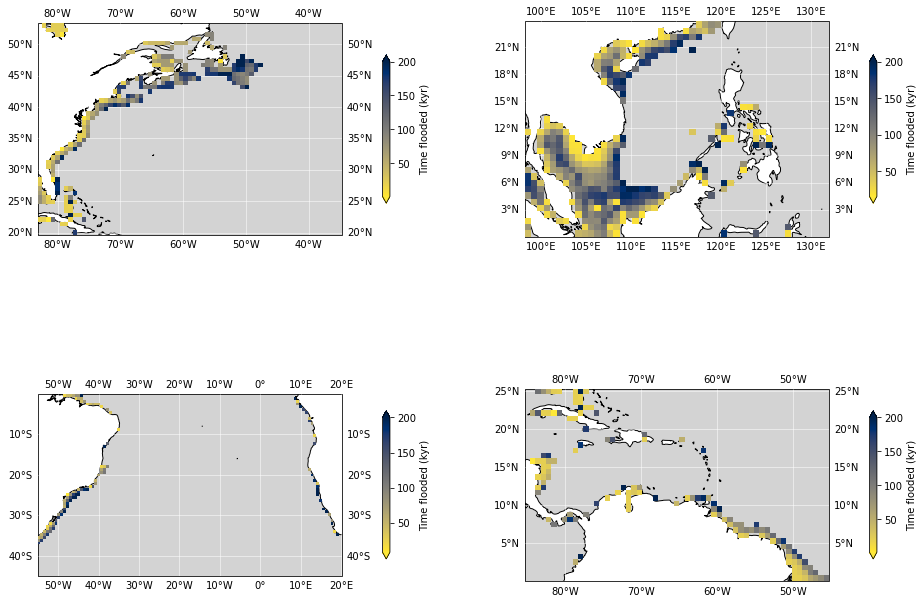

In [ ]:
ds_timeflooded = ds_fullmask.rsl.sum('age') / 4
ds_timeflooded = xr.where(ds_timeflooded < 0.1, np.nan, ds_timeflooded)
fig, ax = plt.subplots(2, 2, figsize=(16, 12), subplot_kw=dict(projection=projection))
axes = ax.flatten()

for loc, ax in zip(['natl', 'scs', 's_atl_n', 'ecarib'], axes):
    
    # choose region
    ds_flood = get_atl(ds_timeflooded, loc, flip=1)
    ds_flood.transpose().plot(ax=ax, 
                                transform=projection, 
                                zorder=10,
                                cmap='cividis_r',
                                cbar_kwargs={'shrink':0.5,
                                              'pad':0.1,
                                               'extend':'both',
                                               'label':'Time flooded (kyr)'})


[add_features(a) for a in axes]

# fig.savefig(f'figs/{loc}/{loc}{i}')
plt.show()

# Get timeseries of RSL at location of cores 

In [ ]:
def save_timeseries(latdeg, latsec, londeg, lonsec, name):
    lat = latdeg + latsec/60
    lon = londeg + lonsec/60
    
    df_atl = ds_6g.interp(lat=lat, lon=lon).rsl.to_dataframe()[['rsl']].reset_index()
    p = '/Users/rogercreel/Dropbox/ws/d15n/output/timeseries/'
    
    df_atl.to_csv(p + f'{name}.csv', index=False)

    
save_timeseries(latdeg=-30, latsec=-16, londeg=-35, lonsec=-17, name='DSDP516')
save_timeseries(latdeg=31, latsec=39, londeg=-38, lonsec=-34, name='MSM58-50-3')

df, df2 = [pd.read_csv(f'/Users/rogercreel/Dropbox/ws/d15n/output/timeseries/{n}.csv') for n in ['DSDP516', 
                                                                                                 'MSM58-50-3']]


<AxesSubplot: xlabel='age'>

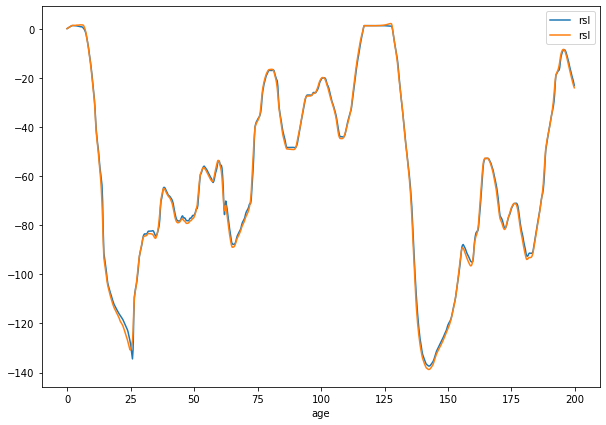

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
df.plot(ax=ax, x='age', y='rsl')
df2.plot(ax=ax,x='age', y='rsl')

# Make global map of shelf area

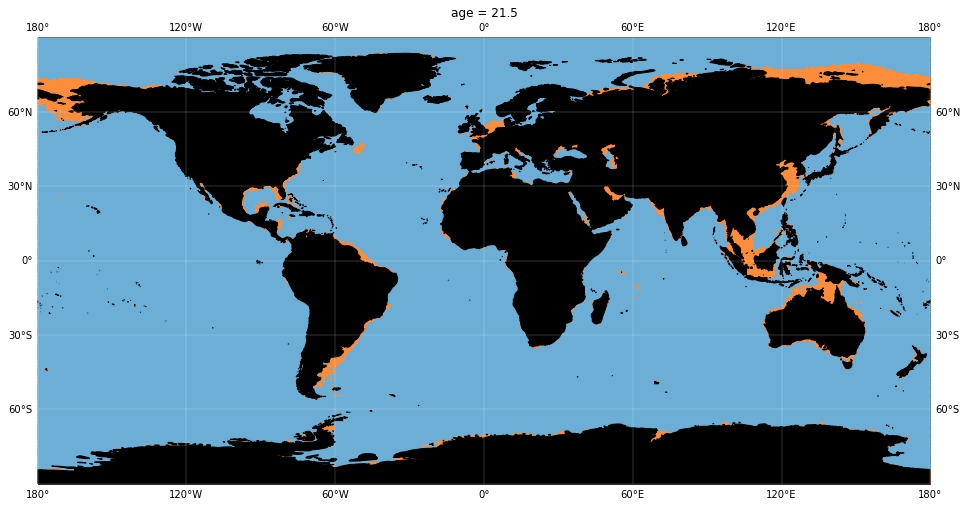

In [ ]:
loc = 'world'
landcolor='k'
shelfcolor='Oranges' # 'Orange'
seacolor='Blues'

fig, ax = plt.subplots(1, 1, figsize=(16, 12), subplot_kw=dict(projection=projection))

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')
# ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')

# ax.add_feature(ocean_50m, color='white', zorder=0)
ax.add_feature(land_50m, color=landcolor, zorder=12)
ax.gridlines(linewidth=0.4, color='white', alpha=0.5, draw_labels=True, zorder=13)

make_plotpart(ds_lgm_land, z=9, cmap=shelfcolor, vmin=1, ax=ax, add_colorbar=False)
make_plotpart(ds_lgm_shelf, z=10, cmap=shelfcolor, vmin=1, ax=ax, add_colorbar=False)
make_plotpart(ds_lgm_wet, z=10, cmap=seacolor, vmin=1, ax=ax, add_colorbar=False)
# make_plotpart(ds_icelgm_plt, z=15, cmap='viridis', vmin=0, ax=ax, add_colorbar=False)


# fig.savefig('figs/shelfmaps/lgm_shelfarea_global_red.png', bbox_inches='tight')
# fig.savefig('figs/shelfmaps/lgm_shelfarea_global.svg', bbox_inches='tight')

